# Step 1: Brief description of the problem and data
In this Kaggle competition project, the task is to build a GAN (generative adversarial network) that generates 7,000 to 10,000 Monet-style images.

From Kaggle:
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos.
* The `monet` directories contain Monet paintings. Use these images to train your model.
* The `photo` directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Kaggle describes the files provided as follows:
* **monet_jpg** - 300 Monet paintings sized 256x256 in JPEG format
* **monet_tfrec** - 300 Monet paintings sized 256x256 in TFRecord format
* **photo_jpg** - 7028 photos sized 256x256 in JPEG format
* **photo_tfrec** - 7028 photos sized 256x256 in TFRecord format

The output of this project must be called `images.zip` and contain 7,000 to 10,000 images sized 256x256.

In [25]:
import os
import tensorflow as tf
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
from skimage import io, filters, color
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.util import img_as_float
import numpy as np

# Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
In this step, I will take a look at the data set, call out any areas of concern, and conclude by cleaning the data based on my findings.

The first thing I noticed in the general description of the data above is the data imbalance.  We have 300 Monet paintings and 7028 photos.

## Step 2 Part 1: View Samples and Confirm Dimensions
Next, I'll take a look at 5 examples of Monet paintings and 5 photos to get an idea of the data set, and confirm that the dimensions of all images are indeed 256x256 as stated in the Kaggle description.

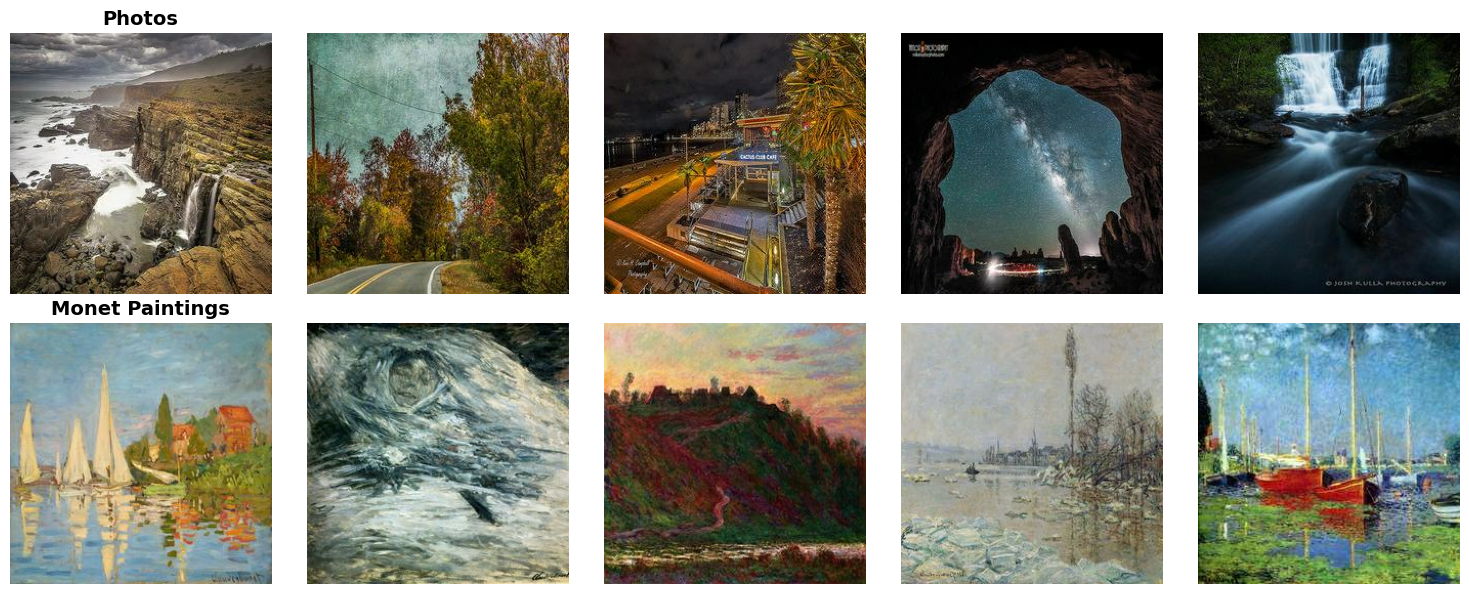

In [5]:
photo_folder = "photo_jpg"
monet_folder = "monet_jpg"

def get_images(folder, num_images=5):
    files = os.listdir(folder)
    image_files = [os.path.join(folder, f) for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
    return image_files[:num_images]

photo_images = get_images(photo_folder)
monet_images = get_images(monet_folder)

def display_images(images, title, start_pos=1):
    for idx, img_path in enumerate(images, start=start_pos):
        img = Image.open(img_path)
        plt.subplot(2, 5, idx)  # Two rows, five images per row
        plt.imshow(img)
        plt.axis('off')
        if idx == start_pos:
            plt.title(title, fontsize=14, fontweight="bold")

plt.figure(figsize=(15, 6))
display_images(photo_images, "Photos", start_pos=1)
display_images(monet_images, "Monet Paintings", start_pos=6)
plt.tight_layout()
plt.show()

In [10]:
def get_image_dimensions_summary(subfolders):
    summary = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        dimensions_counter = Counter()

        if os.path.exists(folder_path):
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.gif')):
                        try:
                            with Image.open(file_path) as img:
                                dimensions_counter[img.size] += 1
                        except Exception as e:
                            print(f"Could not process image {file_path}: {e}")

        summary[subfolder] = dimensions_counter

    return summary

subfolders_to_check = ["monet_jpg", "photo_jpg"]

image_dimensions_summary = get_image_dimensions_summary(subfolders_to_check)
for subfolder, dimensions_count in image_dimensions_summary.items():
    print(f"Image dimensions summary in '{subfolder}':")
    for dimension, count in dimensions_count.items():
        print(f"  {dimension[0]}x{dimension[1]}: {count} image(s)")

Image dimensions summary in 'monet_jpg':
  256x256: 300 image(s)
Image dimensions summary in 'photo_jpg':
  256x256: 7038 image(s)


## Step 2 Part 2: Image Quality

Now that the count and dimensions of the provided images has been confirmed to match the info provided by Kaggle, we'll take a look at image quality.  I'll define image quality as blurriness, noise, and corruption.

To start, I'll compute the average noise for the images so that I can look for especially noisy images.

In [20]:
def compute_average_noise(subfolders):
    noise_stats = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        noise_values = []

        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                if not file.lower().endswith(".jpg"):
                    continue

                try:
                    image = io.imread(file_path)
                    if len(image.shape) == 3: # Convert to grayscale if needed
                        image = rgb2gray(image)
                    image = img_as_float(image)
                    stddev = np.std(image)
                    noise_values.append(stddev)

                except UnidentifiedImageError:
                    print(f"Could not process image: {file_path} (possibly corrupted)")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # Compute average noise (standard deviation) if there are noise values
        if noise_values:
            avg_noise = np.mean(noise_values)
            noise_stats[subfolder] = {
                "average_noise": avg_noise,
                "count": len(noise_values),
            }
        else:
            noise_stats[subfolder] = {
                "average_noise": None,
                "count": 0,
            }

    return noise_stats


subfolders_to_check = ["monet_jpg", "photo_jpg"]
noise_statistics = compute_average_noise(subfolders_to_check)

for subfolder, stats in noise_statistics.items():
    print(f"Noise statistics for '{subfolder}':")
    print(f"  Image count: {stats['count']}")
    print(f"  Average noise (standard deviation): {stats['average_noise']:.6f}" if stats["average_noise"] else "  No valid images")


Noise statistics for 'monet_jpg':
  Image count: 300
  Average noise (standard deviation): 0.180934
Noise statistics for 'photo_jpg':
  Image count: 7038
  Average noise (standard deviation): 0.203307


In [22]:
def analyze_image_quality(subfolders, laplacian_var_min=0.002, noise_stddev_max=0.1):
    quality_issues = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        quality_issues[subfolder] = {"blurry": [], "corrupted": [], "noisy": []}
        total_images = 0

        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                if not file.lower().endswith(".jpg"):
                    continue
                total_images += 1

                try:
                    # Check if the image is corrupted
                    with Image.open(file_path) as img:
                        img.verify()
                except UnidentifiedImageError:
                    quality_issues[subfolder]["corrupted"].append(file_path)
                    continue

                try:
                    image = io.imread(file_path)
                    if len(image.shape) == 3:  # Convert RGB to grayscale if needed
                        image = rgb2gray(image)
                    image = img_as_float(image)
                except Exception as e:
                    quality_issues[subfolder]["corrupted"].append(file_path)
                    continue

                # Check for blurriness using variance of Laplacian
                laplacian_var = filters.laplace(image).var()
                if laplacian_var < laplacian_var_min:
                    quality_issues[subfolder]["blurry"].append(file_path)

                # Check for noise using mean and standard deviation
                stddev = np.std(image)
                if stddev > noise_stddev_max:
                    quality_issues[subfolder]["noisy"].append(file_path)

        # Calculate the percentage of each issue type
        if total_images > 0:
            blurry_percentage = (len(quality_issues[subfolder]["blurry"]) / total_images) * 100
            noisy_percentage = (len(quality_issues[subfolder]["noisy"]) / total_images) * 100
            corrupted_percentage = (len(quality_issues[subfolder]["corrupted"]) / total_images) * 100
        else:
            blurry_percentage = noisy_percentage = corrupted_percentage = 0

        quality_issues[subfolder]["blurry_percentage"] = blurry_percentage
        quality_issues[subfolder]["noisy_percentage"] = noisy_percentage
        quality_issues[subfolder]["corrupted_percentage"] = corrupted_percentage
        quality_issues[subfolder]["total_images"] = total_images

    return quality_issues


subfolders_to_check = ["monet_jpg", "photo_jpg"]
quality_issues_summary = analyze_image_quality(subfolders_to_check, laplacian_var_min=0.002, noise_stddev_max=0.3)

for subfolder, issues in quality_issues_summary.items():
    print(f"Quality issues in '{subfolder}':")
    print(f"  Total images: {issues['total_images']}")
    print(f"  Blurry images: {len(issues['blurry'])} ({issues['blurry_percentage']:.2f}%)")
    print(f"  Noisy images: {len(issues['noisy'])} ({issues['noisy_percentage']:.2f}%)")
    print(f"  Corrupted images: {len(issues['corrupted'])} ({issues['corrupted_percentage']:.2f}%)")

    # Code to print list of blurry, noisy, or corrupted images if necessary
    # if issues["blurry"]:
    #     print("  List of blurry images:")
    #     for path in issues["blurry"]:
    #         print(f"    {path}")
    # if issues["noisy"]:
    #     print("  List of noisy images:")
    #     for path in issues["noisy"]:
    #         print(f"    {path}")
    # if issues["corrupted"]:
    #     print("  List of corrupted images:")
    #     for path in issues["corrupted"]:
    #         print(f"    {path}")


Quality issues in 'monet_jpg':
  Total images: 300
  Blurry images: 2 (0.67%)
  Noisy images: 3 (1.00%)
  Corrupted images: 0 (0.00%)
Quality issues in 'photo_jpg':
  Total images: 7038
  Blurry images: 155 (2.20%)
  Noisy images: 216 (3.07%)
  Corrupted images: 0 (0.00%)


## Step 2 Part 3: Color Space Distribution
I'll convert the images to different color spaces (RGB, HSV, and LAB), then compute the average and standard deviation of the channels in each of those color spaces.  I'll also plot a histogram of one image from each folder (monet and photo).

Color space analysis for 'monet_jpg':
  Total images: 300
  RGB mean: [132.96300456 133.72787954 121.57267919]
  RGB std: [48.74986284 46.45941983 49.52400277]
  HSV mean: [0.33935964 0.30487667 0.58195264]
  HSV std: [0.19188804 0.17491721 0.18589824]
  LAB mean: [54.91562015 -1.12849023  6.74883096]
  LAB std: [18.23179818  6.63364267 13.01882744]



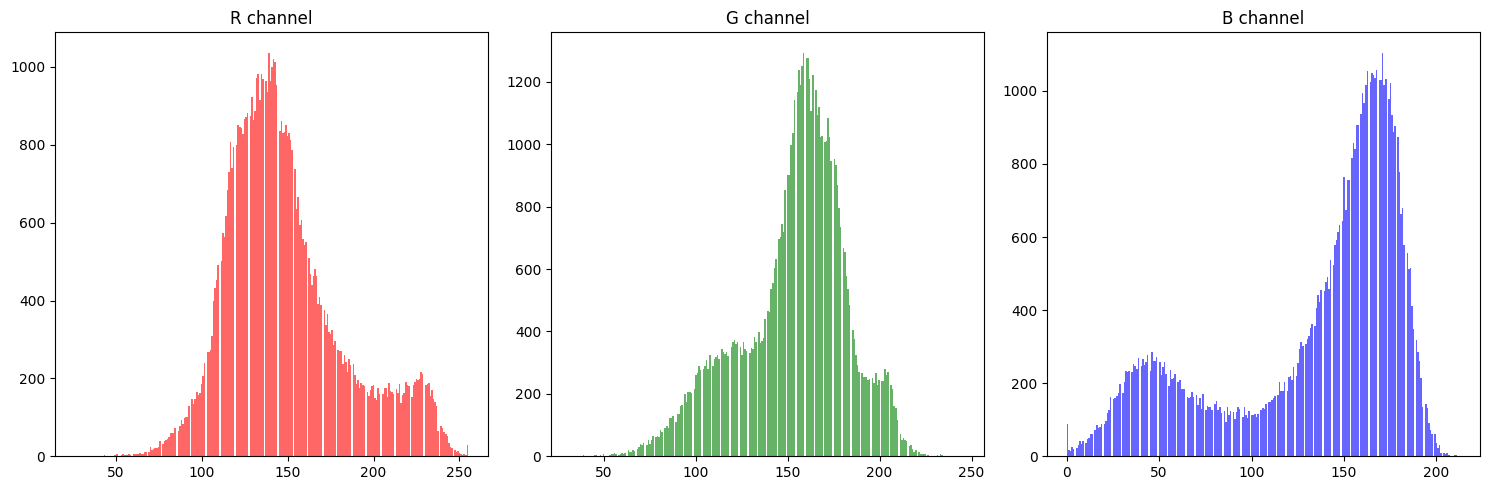

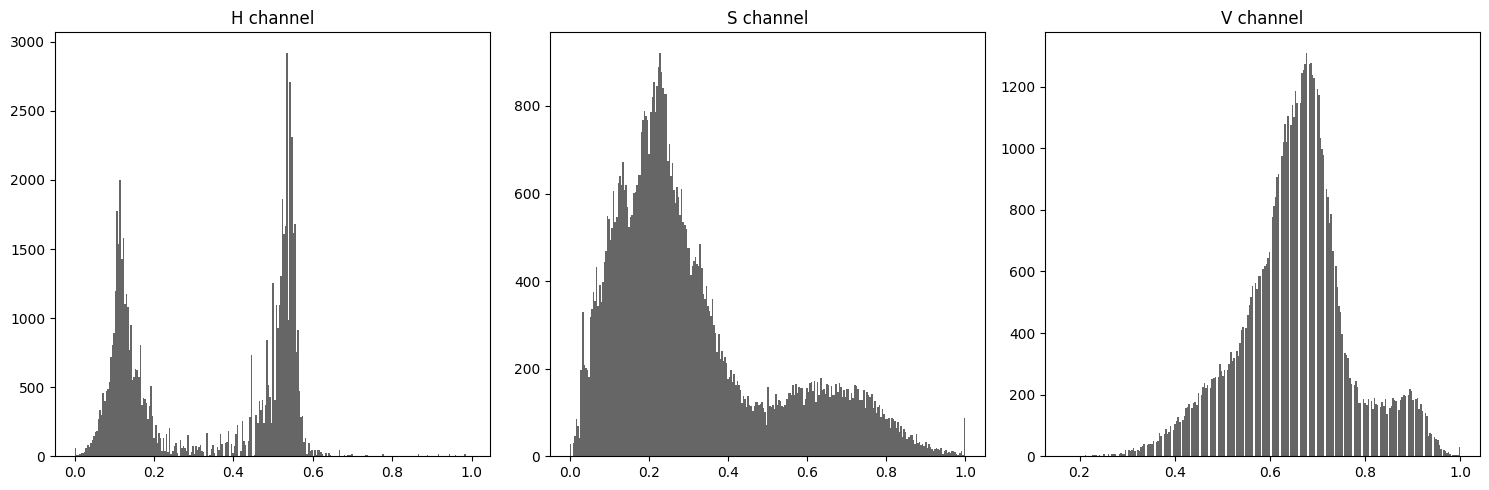

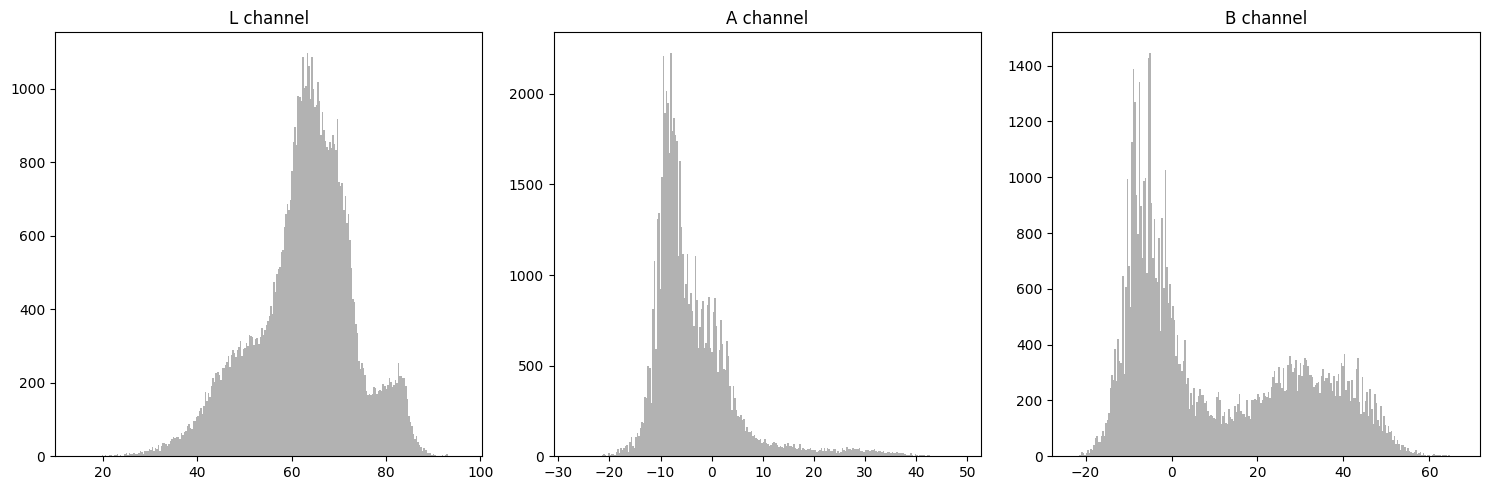

Color space analysis for 'photo_jpg':
  Total images: 7038
  RGB mean: [102.96808675 104.1944681   97.92882523]
  RGB std: [56.58028379 51.70053556 56.0432916 ]
  HSV mean: [0.3470734  0.39772614 0.47955227]
  HSV std: [0.19682639 0.22700811 0.22478036]
  LAB mean: [43.12801966  0.67542049  3.7163903 ]
  LAB std: [21.10943131  6.10424943 14.30241152]



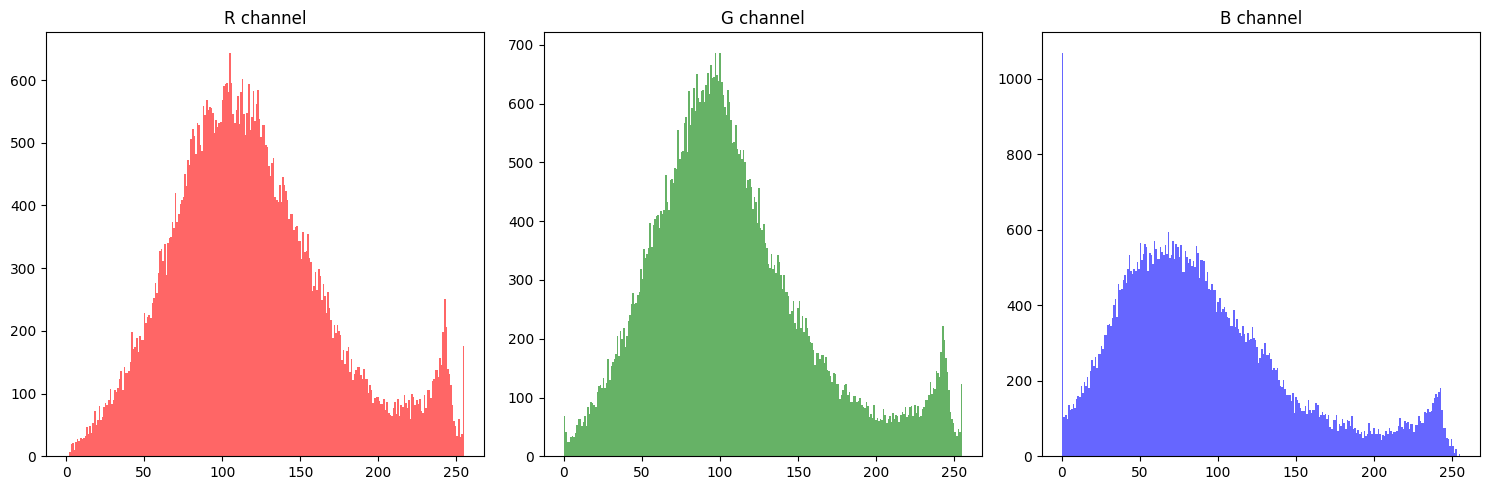

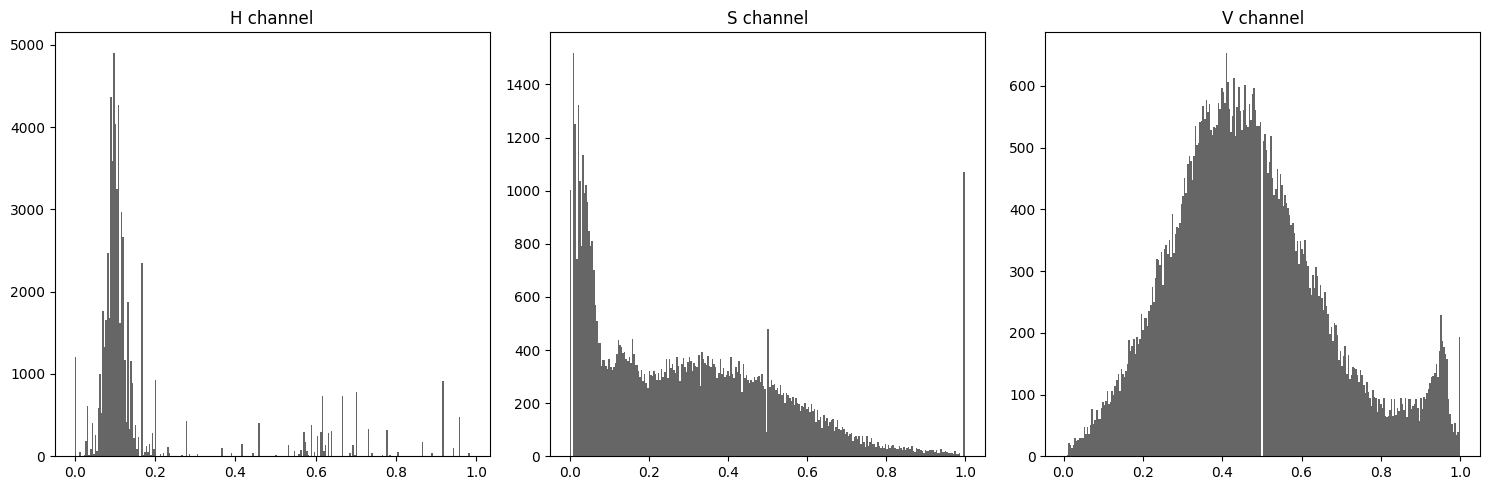

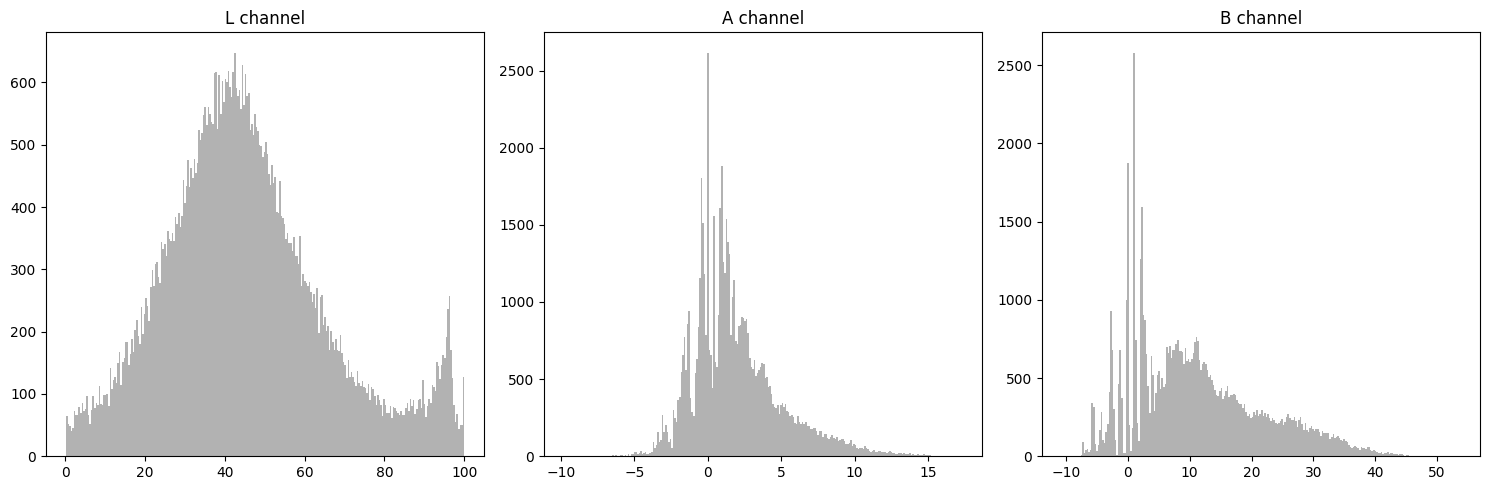

In [26]:
def color_space_analysis(subfolders):
    analysis_results = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        analysis_results[subfolder] = {"rgb": [], "hsv": [], "lab": []}

        total_images = 0
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                if not file.lower().endswith((".jpg")):
                    continue
                total_images += 1

                try:
                    image = io.imread(file_path)

                    # Convert to RGB if the image is in another format
                    if len(image.shape) == 2:  # Grayscale image
                        image = color.gray2rgb(image)
                    elif len(image.shape) == 3 and image.shape[2] == 4:  # RGBA image
                        image = image[:, :, :3]

                    # Convert the image to different color spaces
                    hsv_image = rgb2hsv(image)
                    lab_image = rgb2lab(image)

                    # Calculate statistics for RGB, HSV, and LAB
                    rgb_mean = np.mean(image, axis=(0, 1))
                    rgb_std = np.std(image, axis=(0, 1))
                    hsv_mean = np.mean(hsv_image, axis=(0, 1))
                    hsv_std = np.std(hsv_image, axis=(0, 1))
                    lab_mean = np.mean(lab_image, axis=(0, 1))
                    lab_std = np.std(lab_image, axis=(0, 1))

                    analysis_results[subfolder]["rgb"].append((rgb_mean, rgb_std))
                    analysis_results[subfolder]["hsv"].append((hsv_mean, hsv_std))
                    analysis_results[subfolder]["lab"].append((lab_mean, lab_std))

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        def compute_average_and_std(channel_data):
            if channel_data:
                avg_mean = np.mean([item[0] for item in channel_data], axis=0)
                avg_std = np.mean([item[1] for item in channel_data], axis=0)
                return avg_mean, avg_std
            return None, None

        # Store color statistics for each color space
        rgb_avg_mean, rgb_avg_std = compute_average_and_std(analysis_results[subfolder]["rgb"])
        hsv_avg_mean, hsv_avg_std = compute_average_and_std(analysis_results[subfolder]["hsv"])
        lab_avg_mean, lab_avg_std = compute_average_and_std(analysis_results[subfolder]["lab"])

        analysis_results[subfolder]["rgb_avg_mean"] = rgb_avg_mean
        analysis_results[subfolder]["rgb_avg_std"] = rgb_avg_std
        analysis_results[subfolder]["hsv_avg_mean"] = hsv_avg_mean
        analysis_results[subfolder]["hsv_avg_std"] = hsv_avg_std
        analysis_results[subfolder]["lab_avg_mean"] = lab_avg_mean
        analysis_results[subfolder]["lab_avg_std"] = lab_avg_std
        analysis_results[subfolder]["total_images"] = total_images

    return analysis_results

def plot_histograms(image, color_space):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    if color_space == 'rgb':
        color_channels = ['r', 'g', 'b']
        for i, channel in enumerate(color_channels):
            axes[i].hist(image[:, :, i].ravel(), bins=256, color=channel, alpha=0.6)
            axes[i].set_title(f'{channel.upper()} channel')
    elif color_space == 'hsv':
        color_channels = ['h', 's', 'v']
        hsv_image = rgb2hsv(image)
        for i, channel in enumerate(color_channels):
            axes[i].hist(hsv_image[:, :, i].ravel(), bins=256, color=mcolors.CSS4_COLORS.get(channel, 'black'), alpha=0.6)
            axes[i].set_title(f'{channel.upper()} channel')
    elif color_space == 'lab':
        color_channels = ['l', 'a', 'b']
        lab_image = rgb2lab(image)
        for i, channel in enumerate(color_channels):
            axes[i].hist(lab_image[:, :, i].ravel(), bins=256, color='gray', alpha=0.6)
            axes[i].set_title(f'{channel.upper()} channel')

    plt.tight_layout()
    plt.show()

subfolders_to_check = ["monet_jpg", "photo_jpg"]
color_analysis_results = color_space_analysis(subfolders_to_check)

for subfolder, results in color_analysis_results.items():
    print(f"Color space analysis for '{subfolder}':")
    print(f"  Total images: {results['total_images']}")
    print(f"  RGB mean: {results['rgb_avg_mean']}")
    print(f"  RGB std: {results['rgb_avg_std']}")
    print(f"  HSV mean: {results['hsv_avg_mean']}")
    print(f"  HSV std: {results['hsv_avg_std']}")
    print(f"  LAB mean: {results['lab_avg_mean']}")
    print(f"  LAB std: {results['lab_avg_std']}")
    print()

    # Plot histograms for the first image in the folder
    folder_path = os.path.join(subfolder)
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            if not file.lower().endswith((".jpg")):
                continue

            try:
                image = io.imread(file_path)
                # Show histograms for RGB, HSV, and LAB color spaces
                plot_histograms(image, 'rgb')
                plot_histograms(image, 'hsv')
                plot_histograms(image, 'lab')
                break  # Show histograms only for the first valid image
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

# Step 3: Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).

# Step 4: Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

# Step 5: Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?